In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 250 * pA
B = 250 * pA
R = 80 * Mohm
f = 10*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t < 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t > 5000*ms) * amplitude2 * sin(2*pi*f*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = B  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = B  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 1
p_21     = 0.01

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 1 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 1 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21

Text(0.5, 1.0, '1 -> 2')

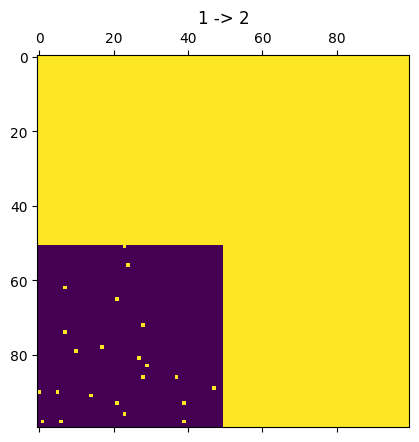

In [2]:
W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('1 -> 2')

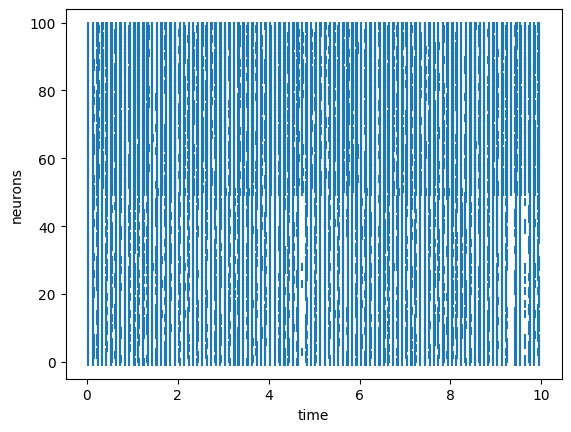

In [3]:
mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)
# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure()
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlabel('time')
plt.ylabel('neurons')
plt.show()

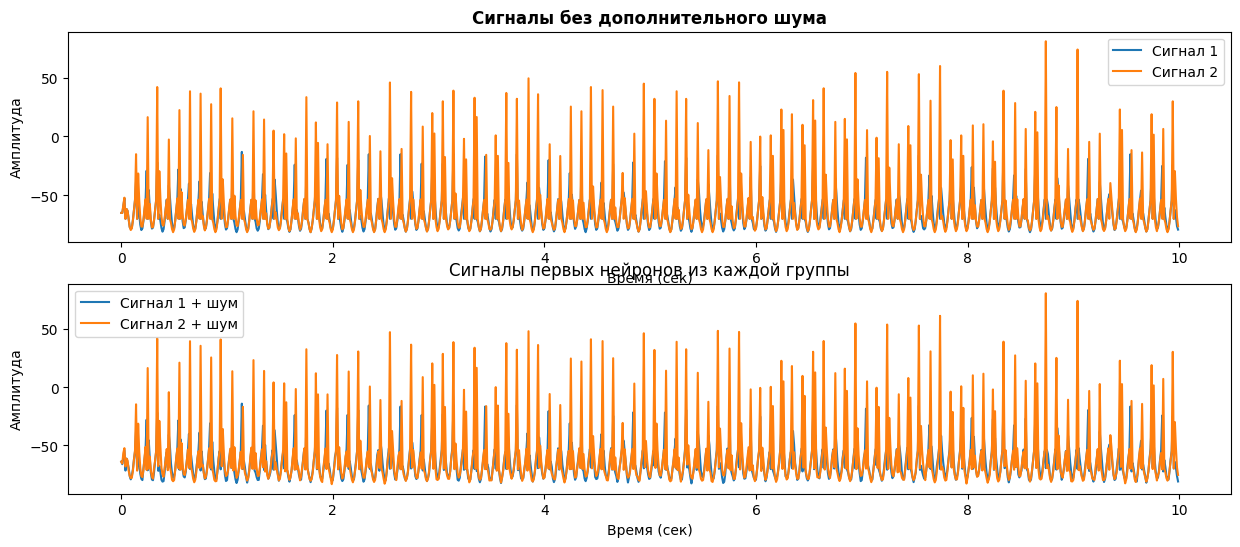

In [4]:
# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].set_title("Сигналы без дополнительного шума", fontweight="bold")
axes[0].plot(t_sim, x1[0], label="Сигнал 1")
axes[0].plot(t_sim, x2[0], label="Сигнал 2")
axes[0].set_xlabel("Время (сек)")
axes[0].set_ylabel("Амплитуда")
axes[0].legend()

axes[1].set_title("Сигналы с дополнительным шумом", fontweight="bold")
axes[1].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
axes[1].set_xlabel("Время (сек)")
axes[1].set_ylabel("Амплитуда")
axes[1].legend()

plt.title("Сигналы первых нейронов из каждой группы")
plt.show()

(1000, 50, 2)


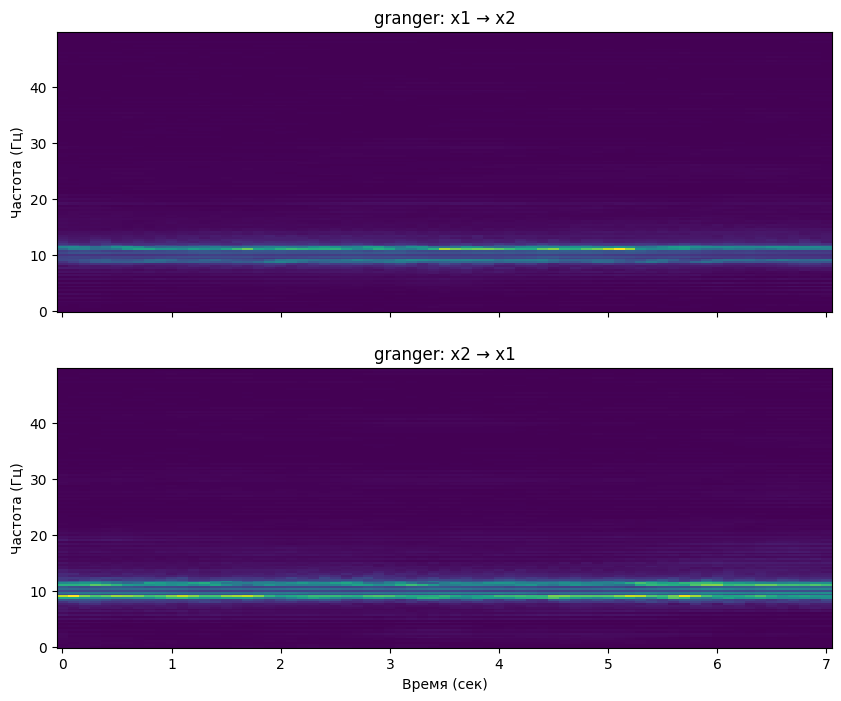

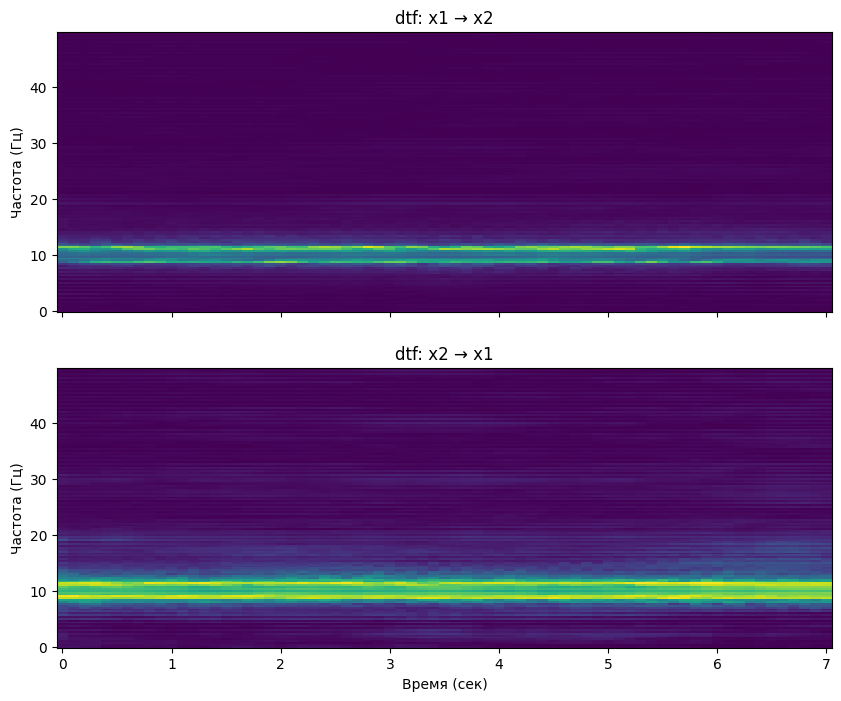

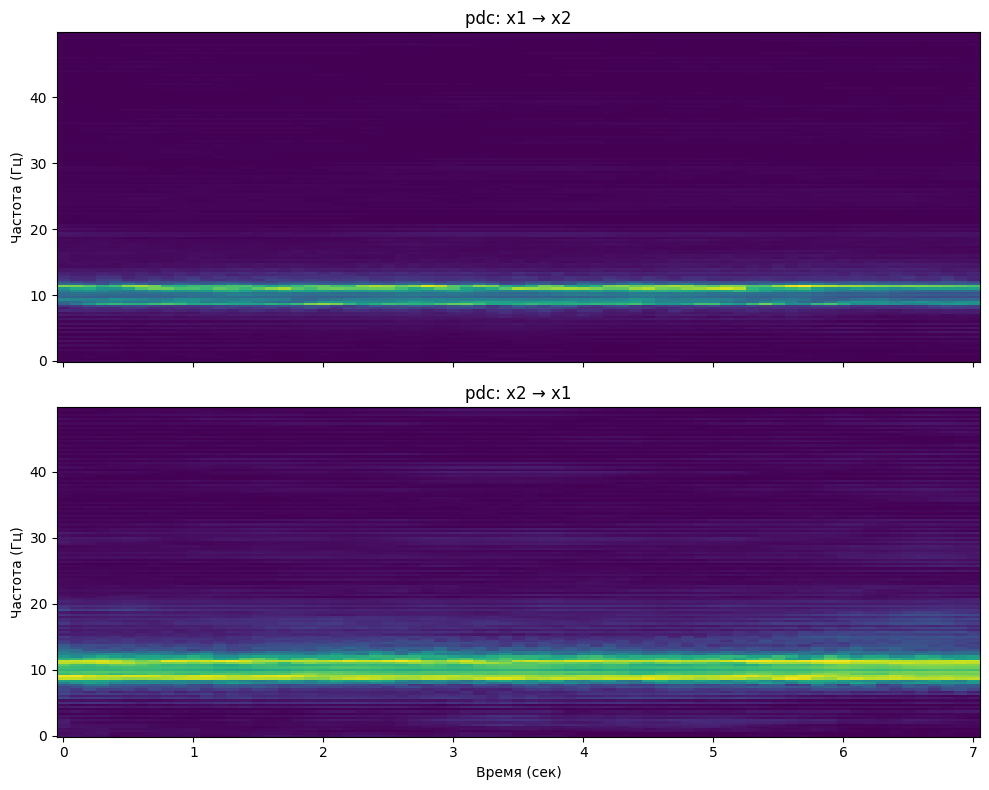

In [5]:
print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=3,
    time_window_step=0.1
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")

plt.tight_layout()
plt.show()

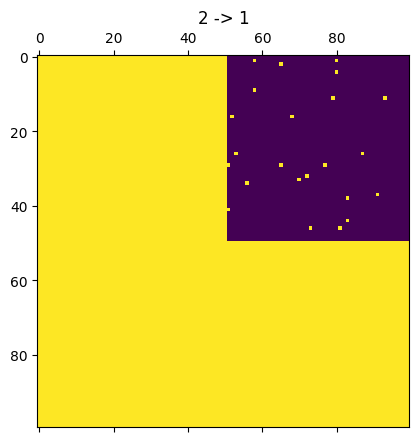

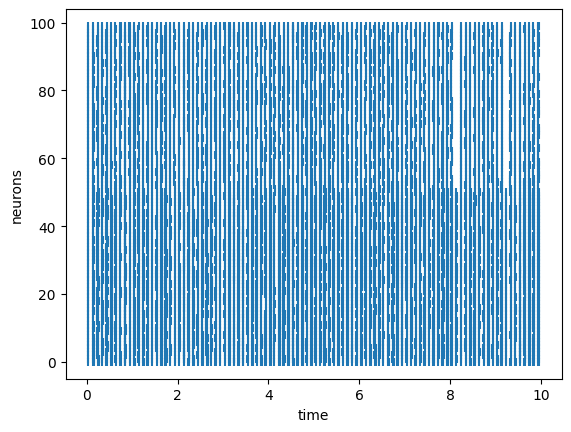

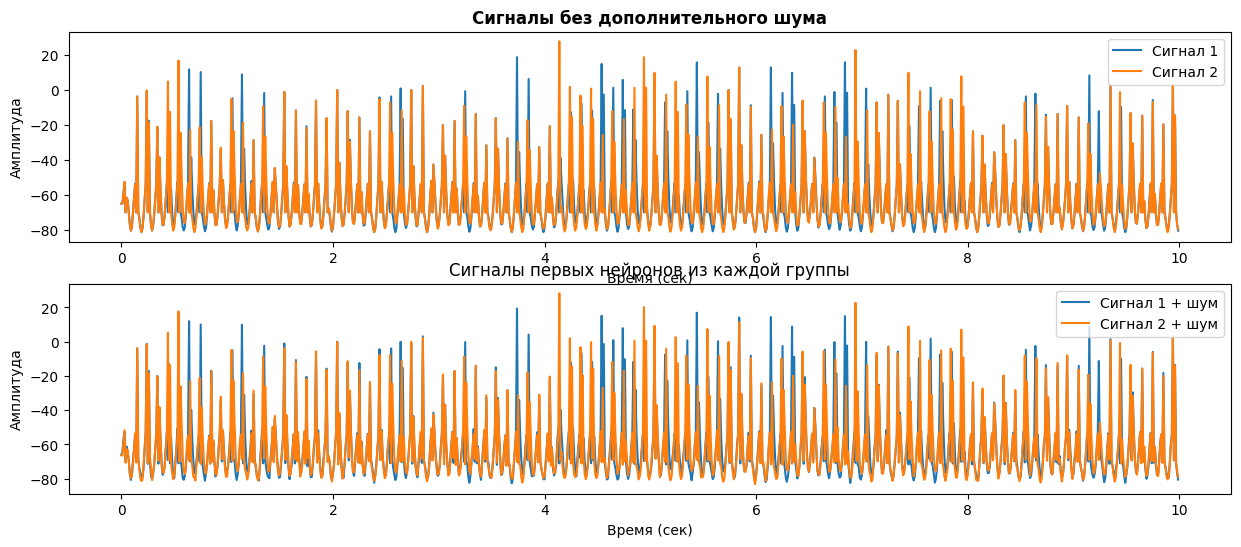

(1000, 50, 2)


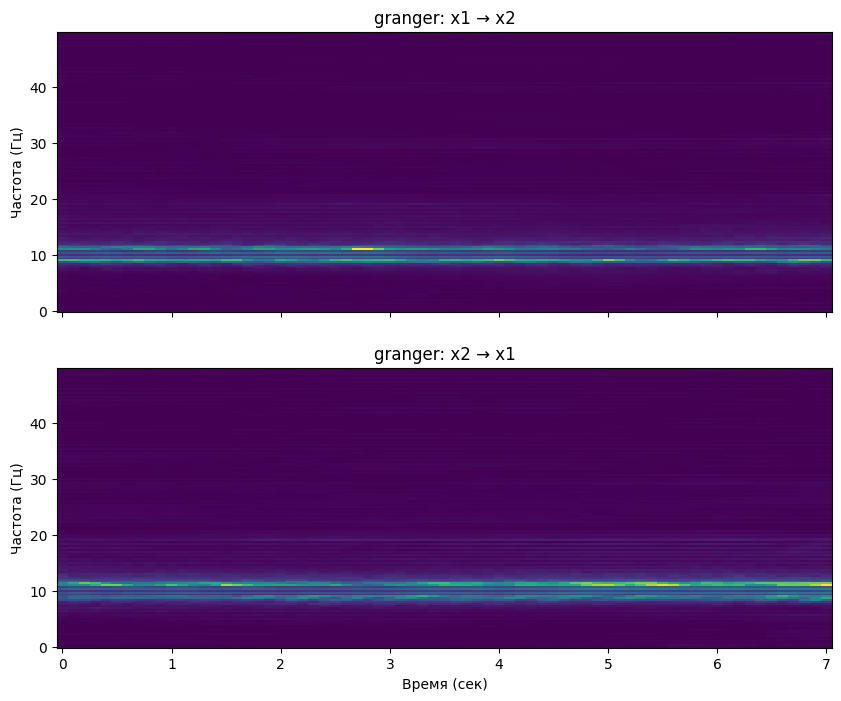

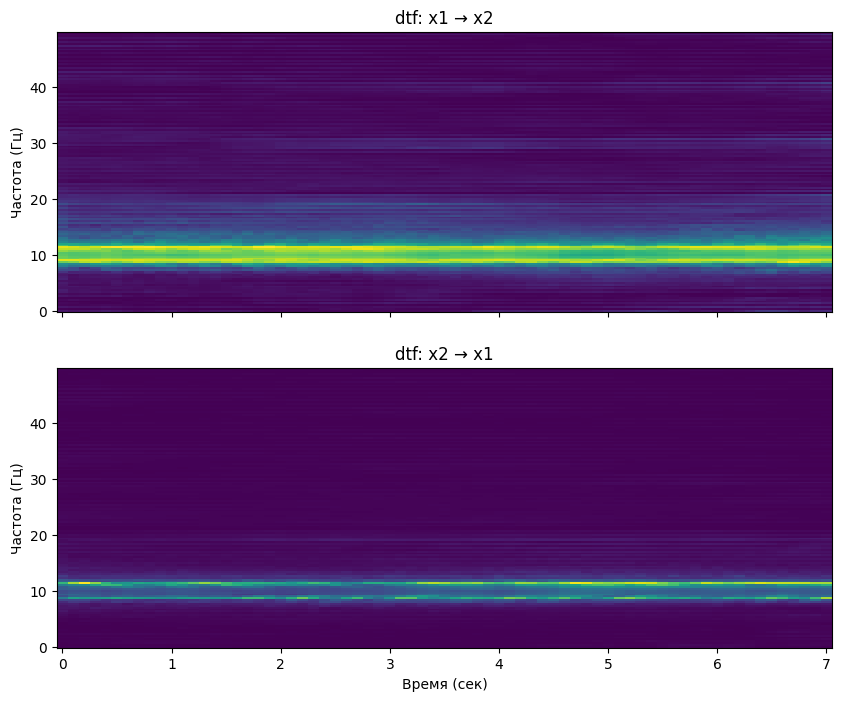

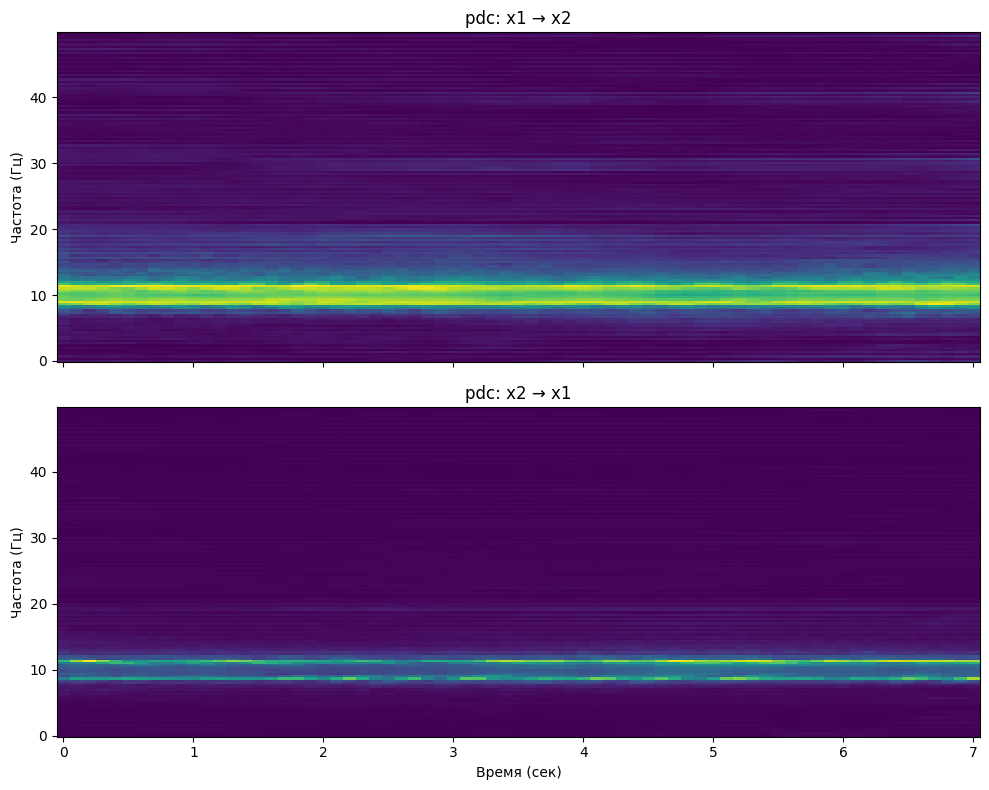

In [6]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 250 * pA
B = 250 * pA
R = 80 * Mohm
f = 10*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t < 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t > 5000*ms) * amplitude2 * sin(2*pi*f*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = B  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = B  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 0.01
p_21     = 1

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 1 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 1 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21


W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('2 -> 1')

mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)


# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure()
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlabel('time')
plt.ylabel('neurons')
plt.show()

# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

axes[0].set_title("Сигналы без дополнительного шума", fontweight="bold")
axes[0].plot(t_sim, x1[0], label="Сигнал 1")
axes[0].plot(t_sim, x2[0], label="Сигнал 2")
axes[0].set_xlabel("Время (сек)")
axes[0].set_ylabel("Амплитуда")
axes[0].legend()

axes[1].set_title("Сигналы с дополнительным шумом", fontweight="bold")
axes[1].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
axes[1].set_xlabel("Время (сек)")
axes[1].set_ylabel("Амплитуда")
axes[1].legend()

plt.title("Сигналы первых нейронов из каждой группы")
plt.show()

print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=3,
    time_window_step=0.1
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_ylabel("Частота (Гц)")
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)")
ax[1].set_ylabel("Частота (Гц)")

plt.tight_layout()
plt.show()

# 1

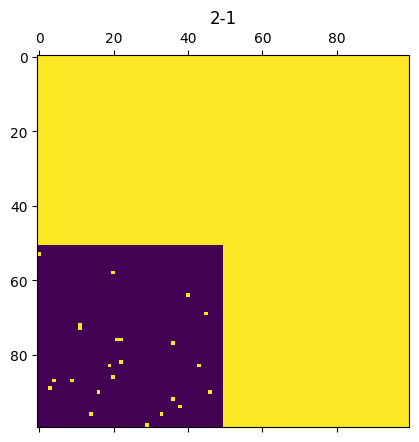

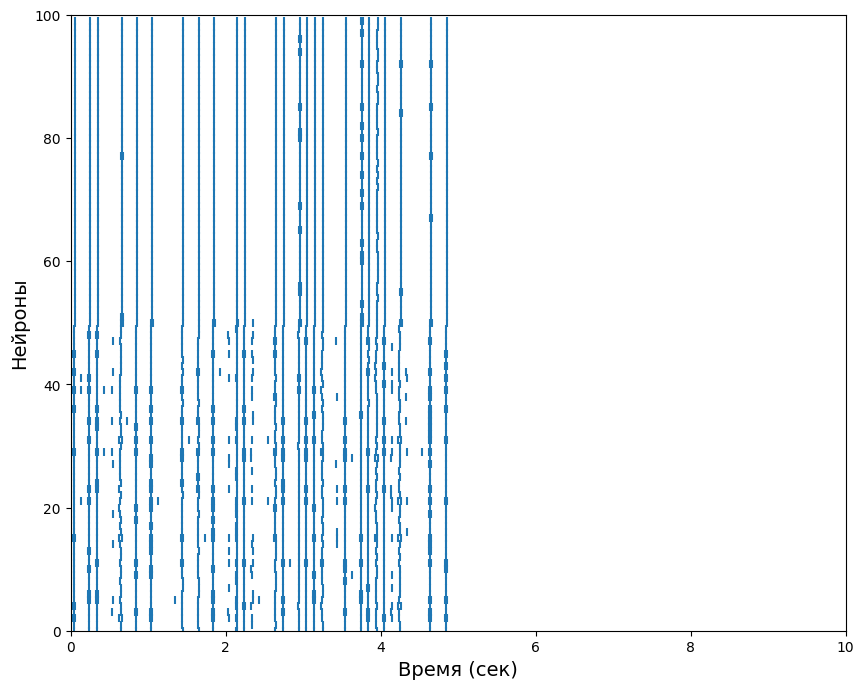

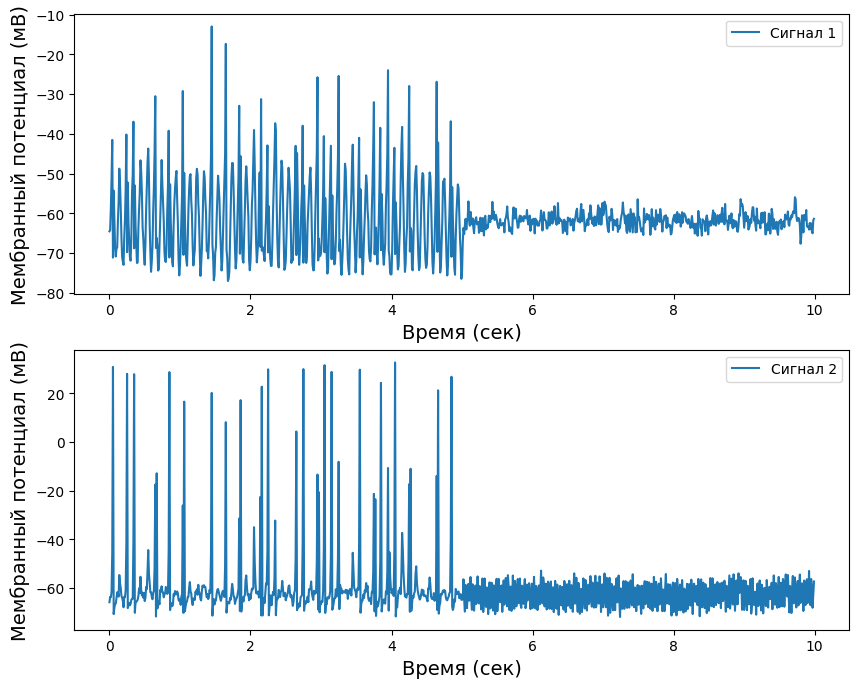

(1000, 50, 2)


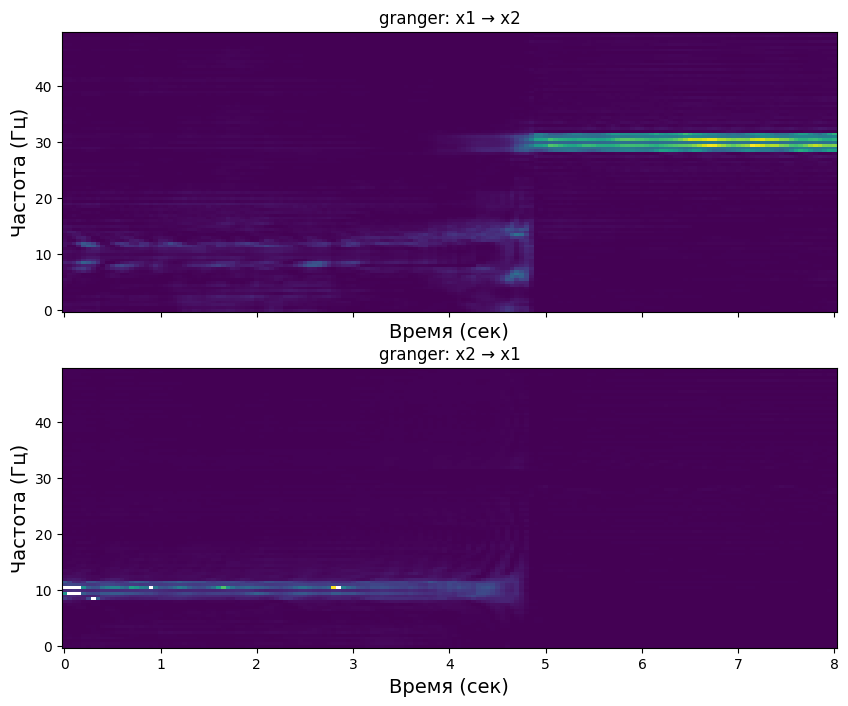

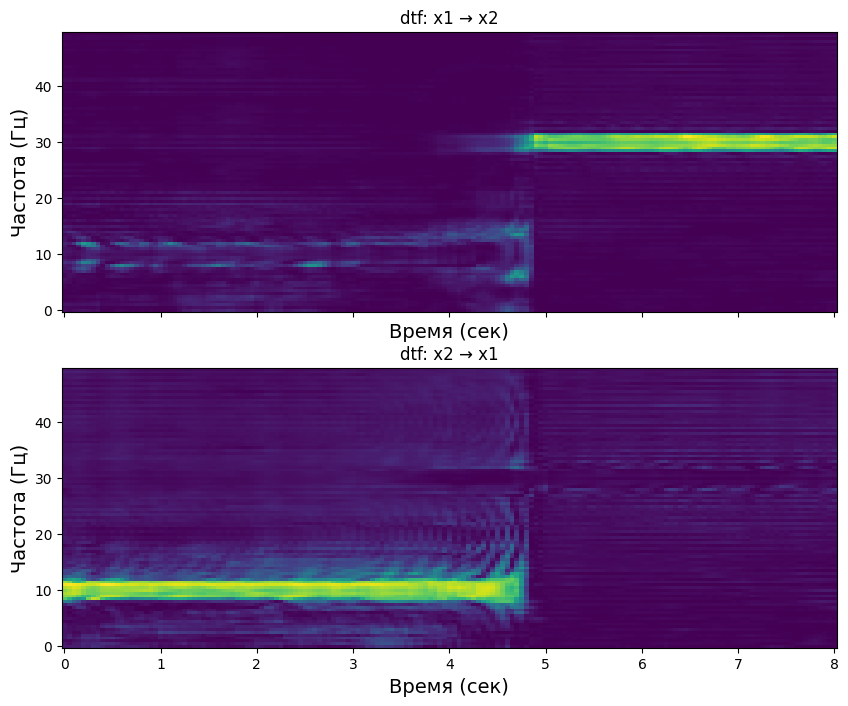

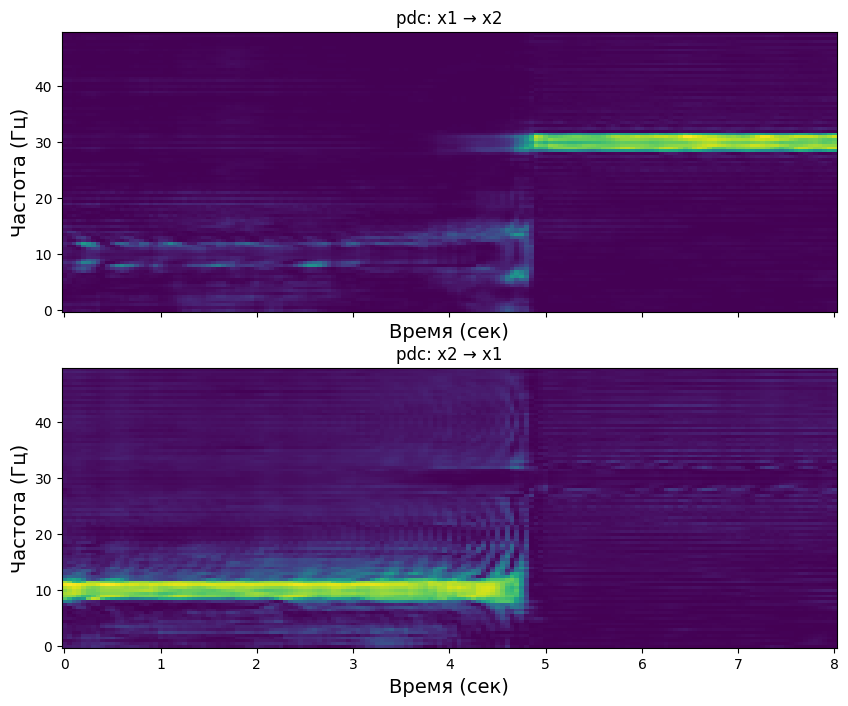

In [7]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 200 * pA
B = 25 * pA
R = 80 * Mohm
f = 10*Hz  
f2 = 30*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t < 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t >= 5000*ms) * amplitude2 * sin(2*pi*f2*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = B  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = B  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 1
p_21     = 0.01

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 10 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 10 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21


W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('2-1')

mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)


# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure(figsize=(10, 8))
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlim(0,10)
plt.ylim(0,100)
plt.xlabel('Время (сек)', fontsize=14)
plt.ylabel('Нейроны', fontsize=14)
plt.show()

# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1")
axes[0].set_xlabel("Время (сек)", fontsize=14)
axes[0].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[0].legend()

axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2")
axes[1].set_xlabel("Время (сек)", fontsize=14)
axes[1].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[1].legend()

# axes[2].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[2].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[2].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[2].set_xlabel("Время (сек)")
# axes[2].set_ylabel("Амплитуда")
# axes[2].set_xlim(0,1)
# axes[2].legend()

# axes[3].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[3].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[3].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[3].set_xlabel("Время (сек)")
# axes[3].set_ylabel("Амплитуда")
# axes[3].set_xlim(9,10)
# axes[3].legend()

plt.show()

print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=2,
    time_window_step=0.05
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# В представленной визуализации «x1 → x2» означает, что анализ показывает влияние (в терминах Грейнджеровой причинности) 
# от временного ряда x1 на временной ряд x2. Это означает, что прошлые значения x1 содержат информацию, которая улучшает прогнозирование 
# будущих значений x2, по сравнению с использованием только информации из x2. Аналогично, «x2 → x1» указывает на влияние в обратном направлении,
# то есть прошлые значения x2 помогают предсказать будущие значения x1.

# При спектральном анализе такая причинность оценивается по частотному содержанию сигналов, что позволяет исследовать, 
# на каких частотах наблюдается статистически значимое направленное влияние между сигналами. 
# Таким образом, каждая из двух панелей на графике иллюстрирует, как меняется эта причинность во времени и по частотам.
# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

plt.show()

# 2

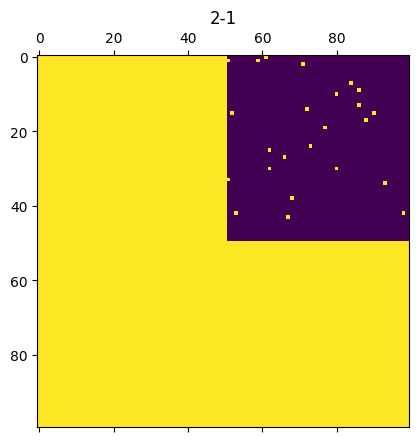

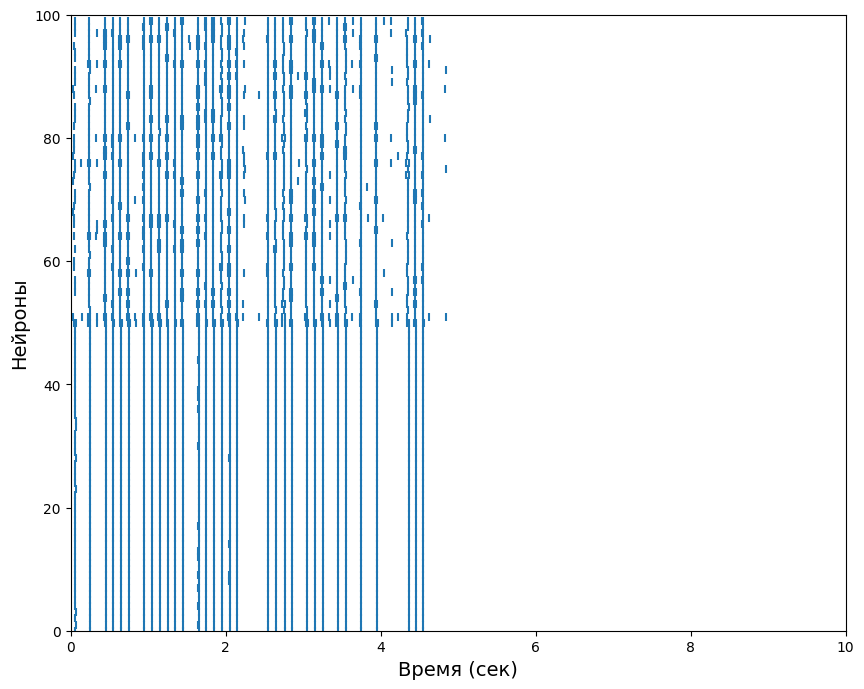

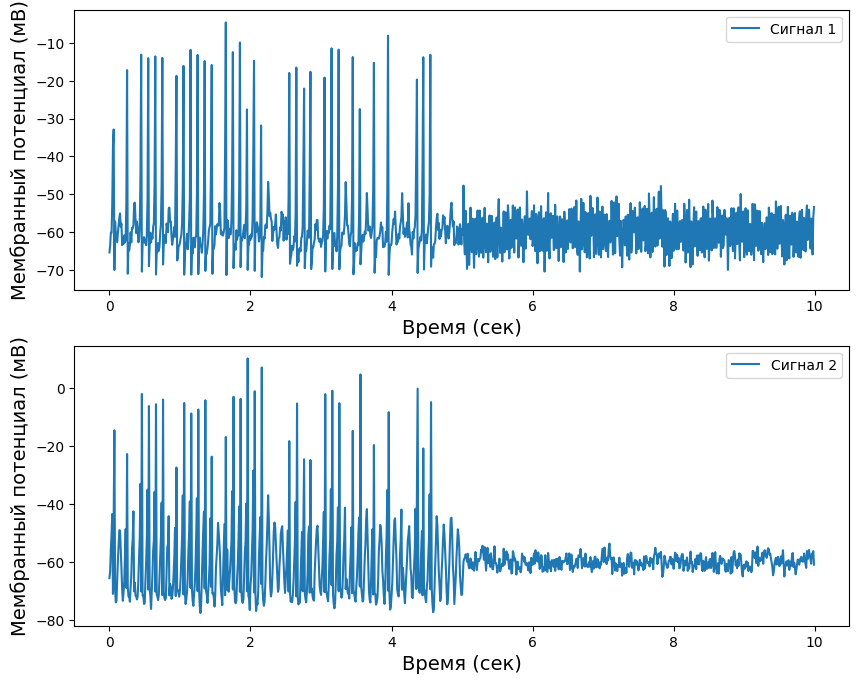

(1000, 50, 2)


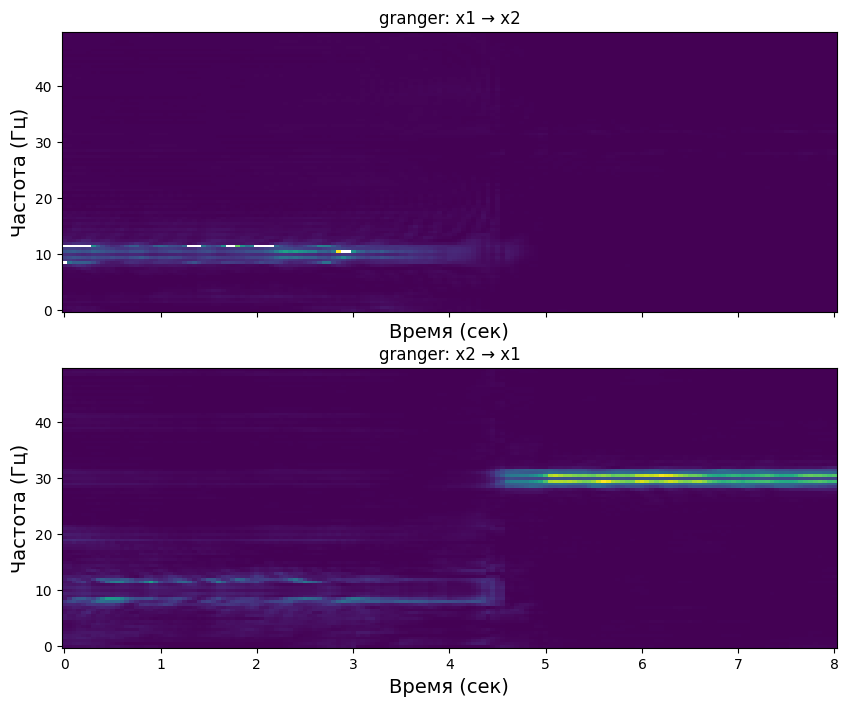

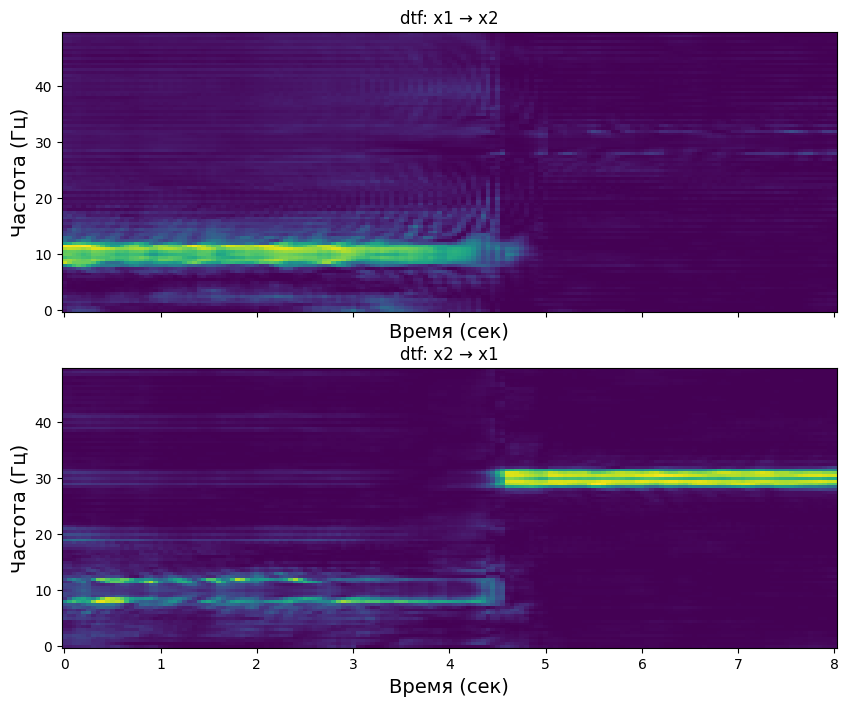

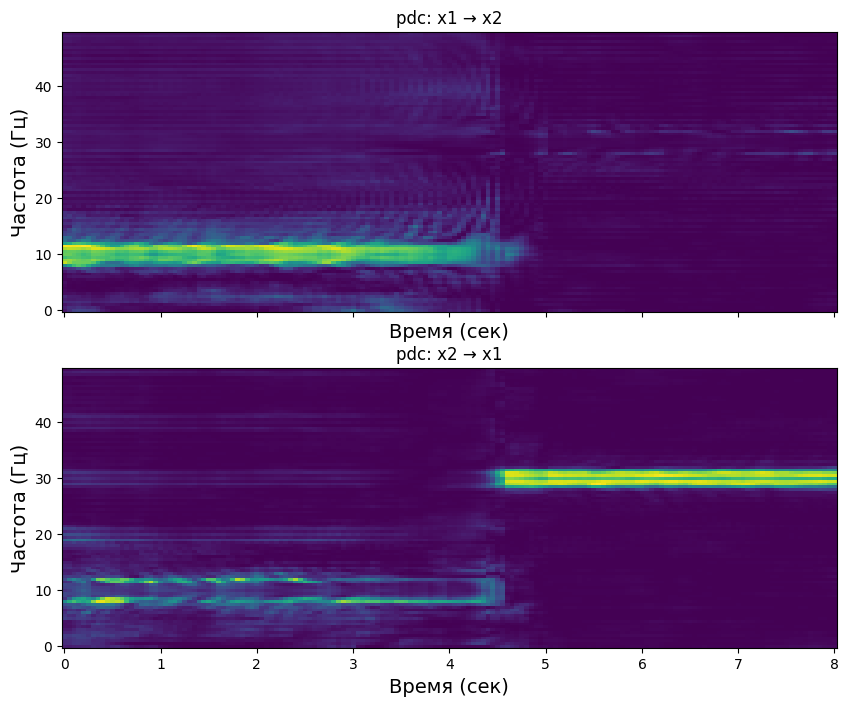

In [8]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 200 * pA
B = 25 * pA
R = 80 * Mohm
f = 10*Hz  
f2 = 30*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t < 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t >= 5000*ms) * amplitude2 * sin(2*pi*f2*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = B  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = A  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = B  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = A  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 0.01
p_21     = 1

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 10 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 10 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21


W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('2-1')

mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)


# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure(figsize=(10, 8))
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlim(0,10)
plt.ylim(0,100)
plt.xlabel('Время (сек)', fontsize=14)
plt.ylabel('Нейроны', fontsize=14)
plt.show()

# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1")
axes[0].set_xlabel("Время (сек)", fontsize=14)
axes[0].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[0].legend()

axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2")
axes[1].set_xlabel("Время (сек)", fontsize=14)
axes[1].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[1].legend()

# axes[2].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[2].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[2].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[2].set_xlabel("Время (сек)")
# axes[2].set_ylabel("Амплитуда")
# axes[2].set_xlim(0,1)
# axes[2].legend()

# axes[3].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[3].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[3].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[3].set_xlabel("Время (сек)")
# axes[3].set_ylabel("Амплитуда")
# axes[3].set_xlim(9,10)
# axes[3].legend()

plt.show()

print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=2,
    time_window_step=0.05
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# В представленной визуализации «x1 → x2» означает, что анализ показывает влияние (в терминах Грейнджеровой причинности) 
# от временного ряда x1 на временной ряд x2. Это означает, что прошлые значения x1 содержат информацию, которая улучшает прогнозирование 
# будущих значений x2, по сравнению с использованием только информации из x2. Аналогично, «x2 → x1» указывает на влияние в обратном направлении,
# то есть прошлые значения x2 помогают предсказать будущие значения x1.

# При спектральном анализе такая причинность оценивается по частотному содержанию сигналов, что позволяет исследовать, 
# на каких частотах наблюдается статистически значимое направленное влияние между сигналами. 
# Таким образом, каждая из двух панелей на графике иллюстрирует, как меняется эта причинность во времени и по частотам.
# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

plt.show()

# 3

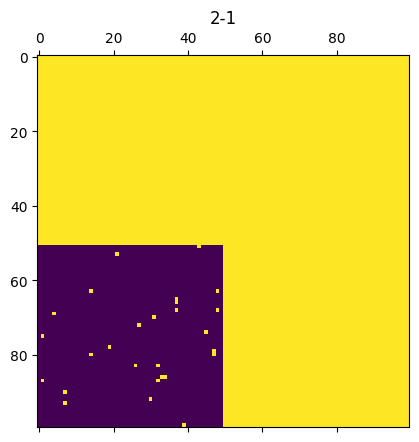

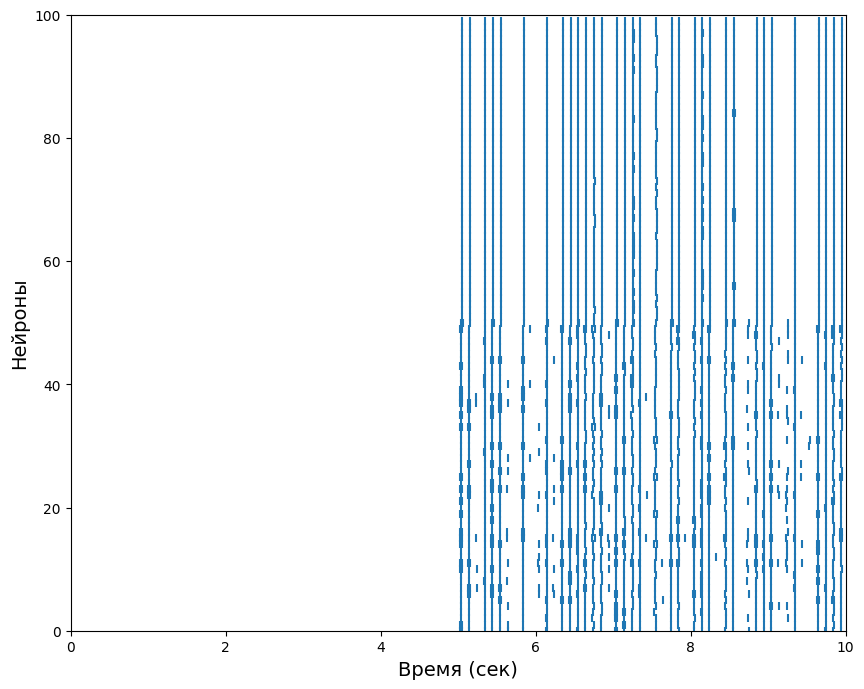

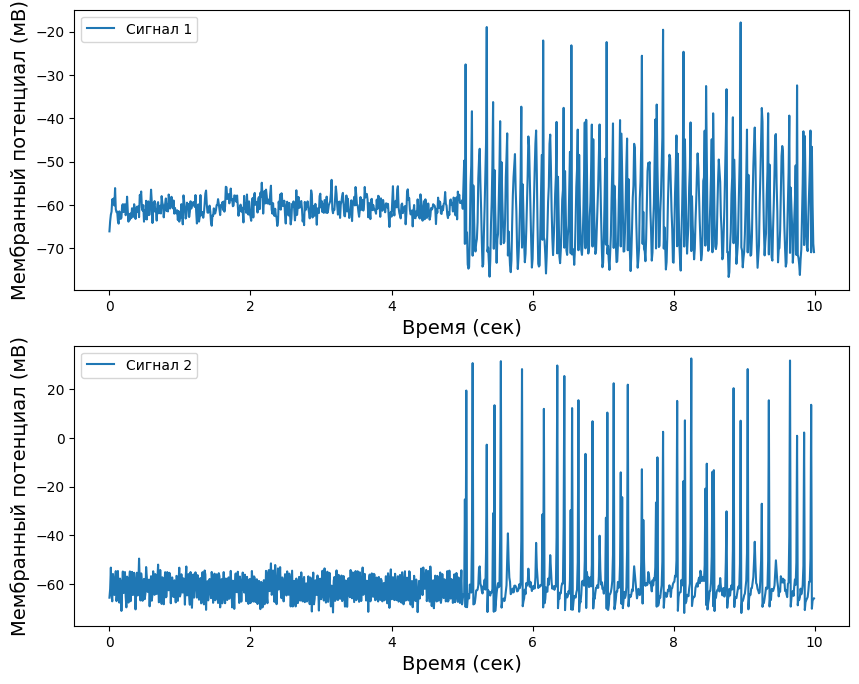

(1000, 50, 2)


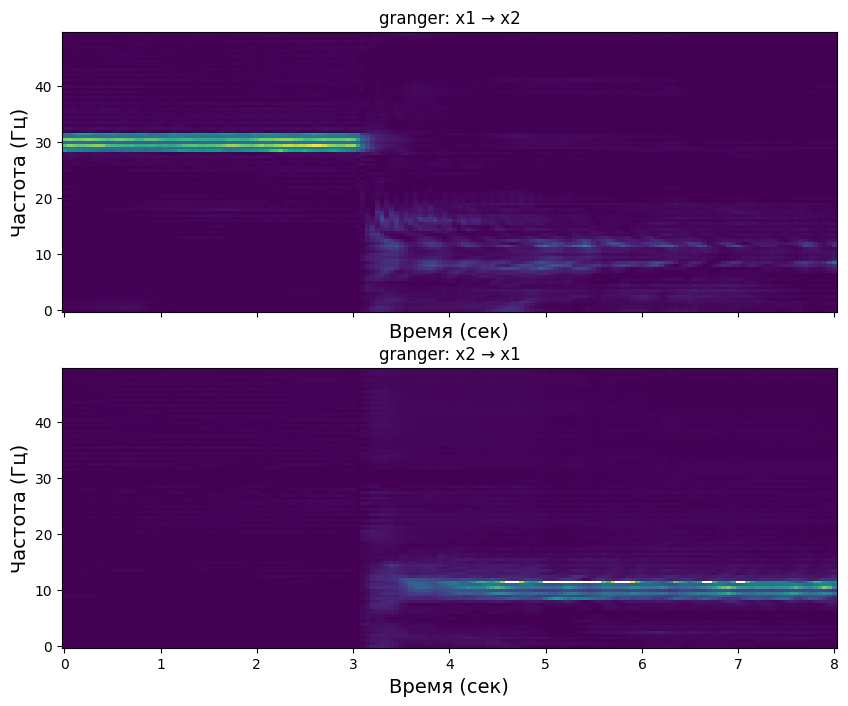

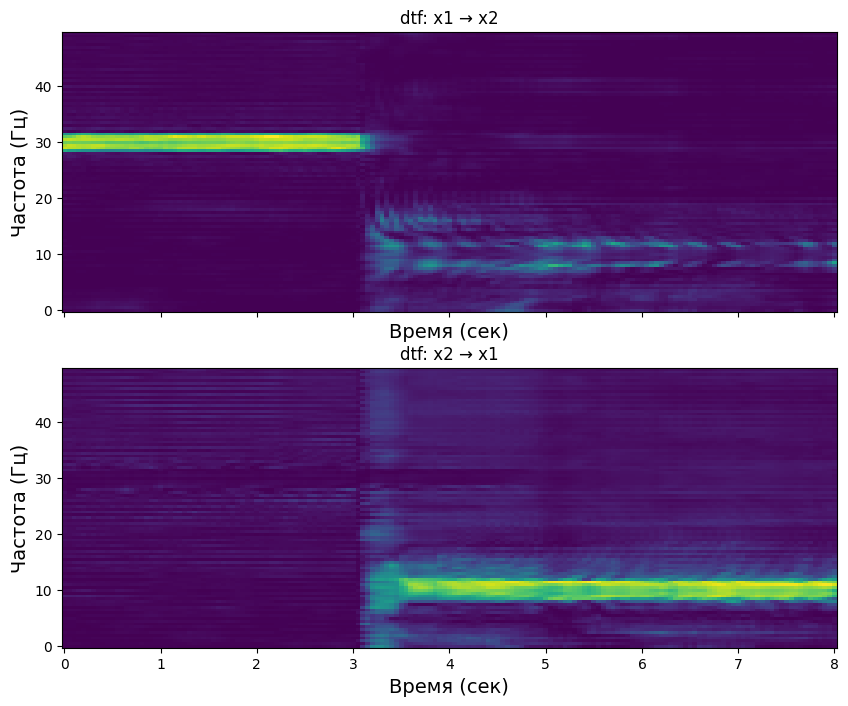

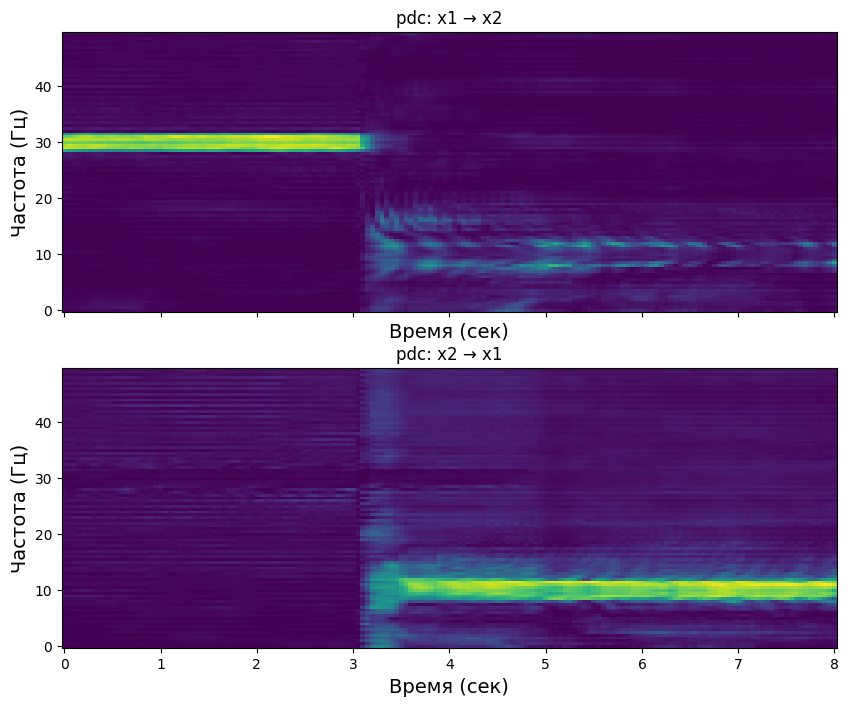

In [9]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 200 * pA
B = 25 * pA
R = 80 * Mohm
f = 10*Hz  
f2 = 30*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t >= 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t < 5000*ms) * amplitude2 * sin(2*pi*f2*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = B  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = A  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = B  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 1
p_21     = 0.01

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 10 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 10 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21


W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('2-1')

mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)


# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure(figsize=(10, 8))
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlim(0,10)
plt.ylim(0,100)
plt.xlabel('Время (сек)', fontsize=14)
plt.ylabel('Нейроны', fontsize=14)
plt.show()

# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1")
axes[0].set_xlabel("Время (сек)", fontsize=14)
axes[0].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[0].legend()

axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2")
axes[1].set_xlabel("Время (сек)", fontsize=14)
axes[1].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[1].legend()

# axes[2].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[2].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[2].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[2].set_xlabel("Время (сек)")
# axes[2].set_ylabel("Амплитуда")
# axes[2].set_xlim(0,1)
# axes[2].legend()

# axes[3].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[3].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[3].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[3].set_xlabel("Время (сек)")
# axes[3].set_ylabel("Амплитуда")
# axes[3].set_xlim(9,10)
# axes[3].legend()

plt.show()

print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=2,
    time_window_step=0.05
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# В представленной визуализации «x1 → x2» означает, что анализ показывает влияние (в терминах Грейнджеровой причинности) 
# от временного ряда x1 на временной ряд x2. Это означает, что прошлые значения x1 содержат информацию, которая улучшает прогнозирование 
# будущих значений x2, по сравнению с использованием только информации из x2. Аналогично, «x2 → x1» указывает на влияние в обратном направлении,
# то есть прошлые значения x2 помогают предсказать будущие значения x1.

# При спектральном анализе такая причинность оценивается по частотному содержанию сигналов, что позволяет исследовать, 
# на каких частотах наблюдается статистически значимое направленное влияние между сигналами. 
# Таким образом, каждая из двух панелей на графике иллюстрирует, как меняется эта причинность во времени и по частотам.
# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

plt.show()

# 4

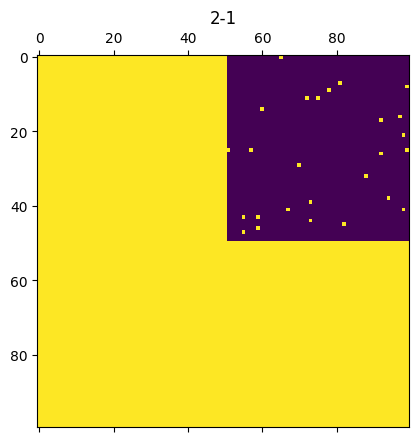

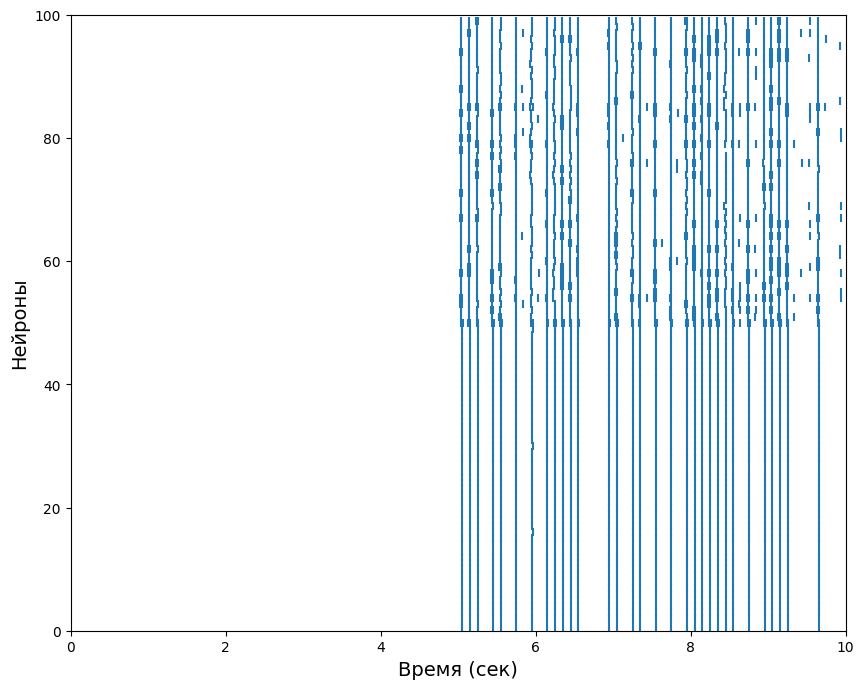

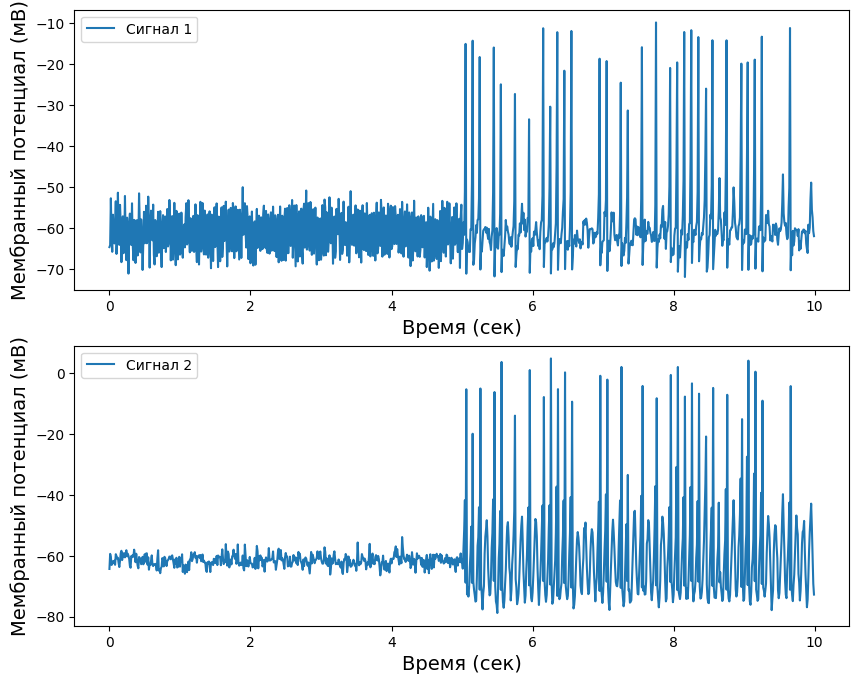

(1000, 50, 2)


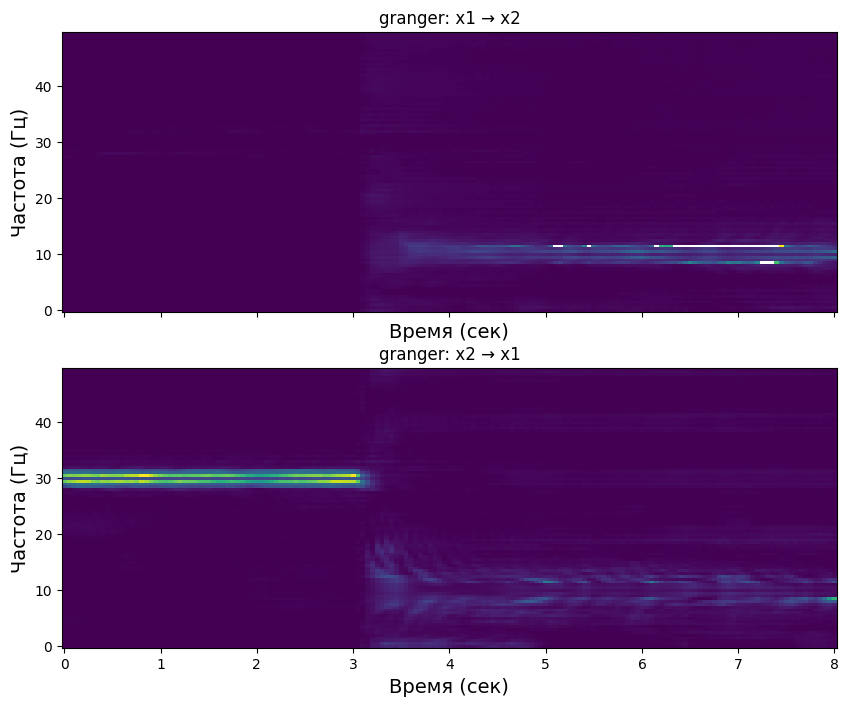

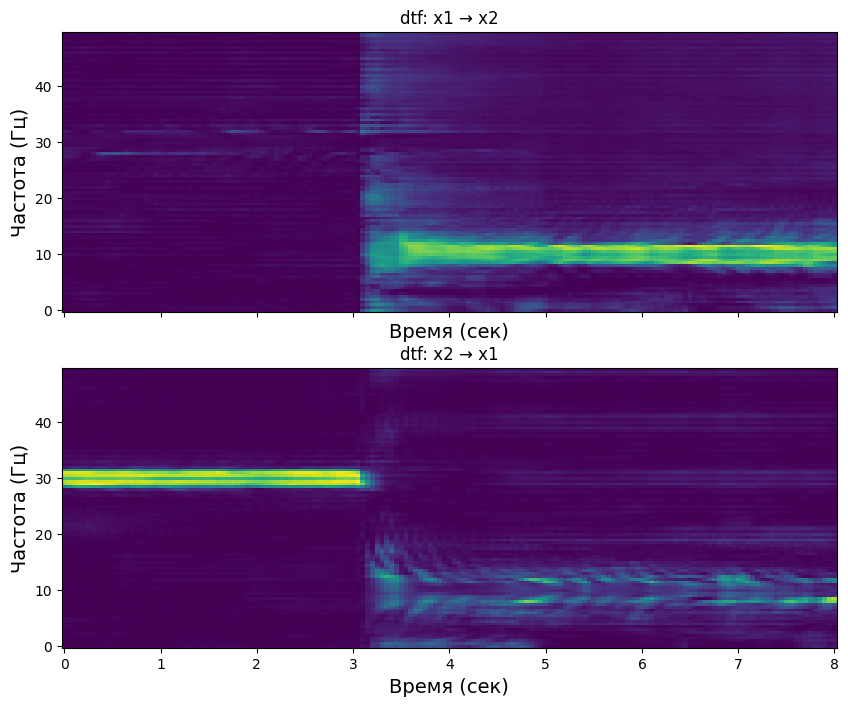

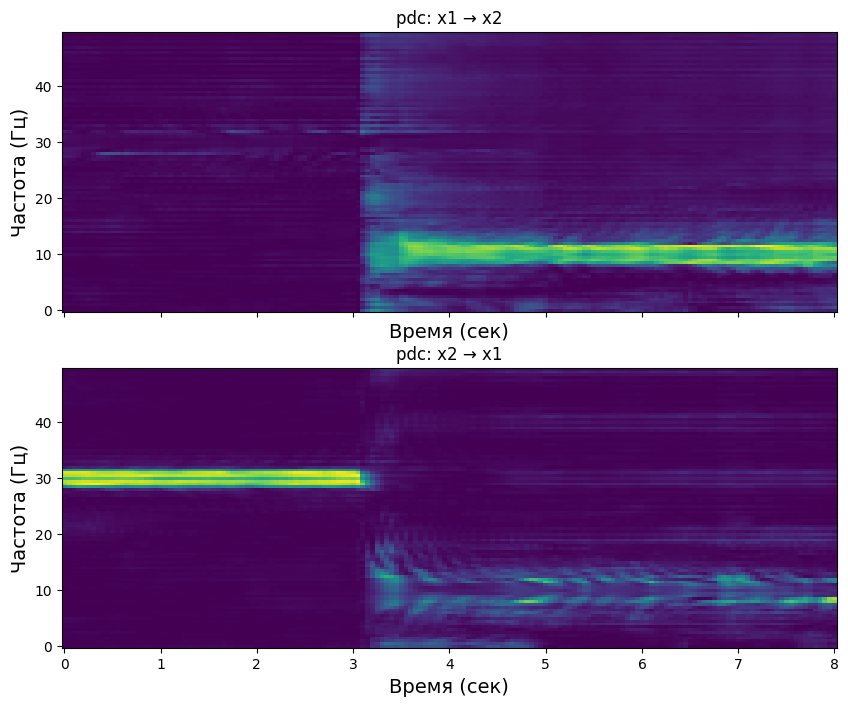

In [10]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper, Connectivity
start_scope()

# Параметры моделирования
sampling_frequency = 100  # Гц (100 - чтобы увидеть частоты 0-40, 200 чтобы увидеть частоты 0-80)
dt_sim = 1 / sampling_frequency  # шаг интегрирования (сек)
defaultclock.dt = dt_sim * second
noise_std = 0.1     # стандартное отклонение шума

# Временные параметры
t_total_sim = 10   # общее время моделирования (сек)
segment_switch = 5  # время переключения драйвера (сек)

n_neurons = 100

A = 200 * pA
B = 25 * pA
R = 80 * Mohm
f = 10*Hz  
f2 = 30*Hz     
tau = 20*ms
phi = 0
J = 1 * mV
eqs = '''
dv/dt = (v_rest-v+R*(I_half1+I_half2))/tau :  volt            
I_half1 = int(t >= 5000*ms) * amplitude * sin(2*pi*f*t + phi) : amp              
I_half2 = int(t < 5000*ms) * amplitude2 * sin(2*pi*f2*t + phi) : amp
amplitude : amp 
amplitude2 : amp 
'''
v_threshold = -50 * mV
v_reset = -70 * mV
v_rest =  -65 * mV

G = NeuronGroup(n_neurons, 
                eqs, 
                threshold="v > v_threshold",
                reset="v = v_reset",
                method='euler')
G.v = v_rest
# Задаем различные амплитуды для двух подгрупп нейронов
G.amplitude[:n_neurons//2] = B  # нейроны с 0 по 24 получают амплитуду A
G.amplitude[n_neurons//2:] = A  # нейроны с 25 по 50 получают амплитуду B
G.amplitude2[n_neurons//2:] = B  # нейроны с 0 по 24 получают амплитуду A
G.amplitude2[:n_neurons//2] = A  # нейроны с 25 по 50 получают амплитуду B

p_intra1 = 1
p_intra2 = 1
p_12     = 0.01
p_21     = 1

# Веса соединения
w_intra1 = 1
w_intra2 = 1
w_12     = 1
w_21     = 1

n_half = n_neurons // 2

input_rate = 10 * Hz
input_group = PoissonGroup(n_neurons, rates=input_rate)
syn_input = Synapses(input_group, G[:n_neurons//2], on_pre='v_post += J')
syn_input.connect(p=0.2)

input_rate2 = 10 * Hz
input_group2 = PoissonGroup(n_neurons, rates=input_rate2)
syn_input2 = Synapses(input_group2, G[n_neurons//2:], on_pre='v_post += J')
syn_input2.connect(p=0.2)

S_intra1 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra1.connect(
    condition='i <= n_half and j <= n_half',
    p=p_intra1
)
S_intra1.w = w_intra1

# 2) Синапсы внутри 2-го кластера
S_intra2 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_intra2.connect(
    condition='i >= n_half and j >= n_half',
    p=p_intra2
)
S_intra2.w = w_intra2

# 3) Синапсы из 1-го кластера во 2-й
S_12 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_12.connect(
    condition='i < n_half and j >= n_half',
    p=p_12
)
S_12.w = w_12

# 4) Синапсы из 2-го кластера в 1-й
S_21 = Synapses(G, G, model='w : 1', on_pre='v_post += J * w')
S_21.connect(
    condition='i >= n_half and j < n_half',
    p=p_21
)
S_21.w = w_21


W = np.zeros((n_neurons, n_neurons))
W[S_intra1.i[:], S_intra1.j[:]] = S_intra1.w[:]
W[S_intra2.i[:], S_intra2.j[:]] = S_intra2.w[:]
W[S_12.i[:], S_12.j[:]] = S_12.w[:]
W[S_21.i[:], S_21.j[:]] = S_21.w[:]
plt.matshow(W, cmap='viridis')
plt.title('2-1')

mon = StateMonitor(G, 'v', record=True)
spike_monitor = SpikeMonitor(G)


# Запуск моделирования
run(t_total_sim * second)

spike_times = spike_monitor.t / second
spike_indices = spike_monitor.i
plt.figure(figsize=(10, 8))
plt.scatter(spike_times, spike_indices, marker='|')
plt.xlim(0,10)
plt.ylim(0,100)
plt.xlabel('Время (сек)', fontsize=14)
plt.ylabel('Нейроны', fontsize=14)
plt.show()

# Извлечение данных
t_sim = mon.t/second
x1 = mon.v[:n_neurons//2, :] / mV  # (форма: n_neurons//2, 1000)
x2 = mon.v[n_neurons//2:, :] / mV  # (форма: n_neurons//2, 1000)

trial0 = x1.T  # (1000, n_neurons//2)
trial1 = x2.T  # (1000, n_neurons//2)
signal = np.stack((trial0, trial1), axis=-1)  # (1000, n_neurons//2, 2)

# Добавление фонового шума
signal_noisy = signal + np.random.normal(0, 1, signal.shape)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1")
axes[0].set_xlabel("Время (сек)", fontsize=14)
axes[0].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[0].legend()

axes[1].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2")
axes[1].set_xlabel("Время (сек)", fontsize=14)
axes[1].set_ylabel("Мембранный потенциал (мВ)", fontsize=14)
axes[1].legend()

# axes[2].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[2].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[2].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[2].set_xlabel("Время (сек)")
# axes[2].set_ylabel("Амплитуда")
# axes[2].set_xlim(0,1)
# axes[2].legend()

# axes[3].set_title("Сигналы с дополнительным шумом", fontweight="bold")
# axes[3].plot(t_sim, signal_noisy[:,0,0], label="Сигнал 1 + шум")
# axes[3].plot(t_sim, signal_noisy[:,0,1], label="Сигнал 2 + шум")
# axes[3].set_xlabel("Время (сек)")
# axes[3].set_ylabel("Амплитуда")
# axes[3].set_xlim(9,10)
# axes[3].legend()

plt.show()

print(signal_noisy.shape)
# Спектральный анализ
multitaper = Multitaper(
    signal_noisy,
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=3,
    time_window_duration=2,
    time_window_step=0.05
)

c = Connectivity.from_multitaper(multitaper)

# Расчёт и визуализация Granger Causality
granger = c.pairwise_spectral_granger_prediction()
dtf = c.directed_transfer_function()
pdc = c.partial_directed_coherence()

# В представленной визуализации «x1 → x2» означает, что анализ показывает влияние (в терминах Грейнджеровой причинности) 
# от временного ряда x1 на временной ряд x2. Это означает, что прошлые значения x1 содержат информацию, которая улучшает прогнозирование 
# будущих значений x2, по сравнению с использованием только информации из x2. Аналогично, «x2 → x1» указывает на влияние в обратном направлении,
# то есть прошлые значения x2 помогают предсказать будущие значения x1.

# При спектральном анализе такая причинность оценивается по частотному содержанию сигналов, что позволяет исследовать, 
# на каких частотах наблюдается статистически значимое направленное влияние между сигналами. 
# Таким образом, каждая из двух панелей на графике иллюстрирует, как меняется эта причинность во времени и по частотам.
# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, granger[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("granger: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, granger[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("granger: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)


# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, dtf[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("dtf: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, dtf[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("dtf: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

# Визуализация спектральной Грейнджеровой причинности
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
ax[0].pcolormesh(c.time, c.frequencies, pdc[...,:, 0, 1].T, cmap="viridis", shading="auto")
ax[0].set_title("pdc: x1 → x2")
ax[0].set_xlabel("Время (сек)", fontsize=14)
ax[0].set_ylabel("Частота (Гц)", fontsize=14)
ax[1].pcolormesh(c.time, c.frequencies, pdc[...,:, 1, 0].T, cmap="viridis", shading="auto")
ax[1].set_title("pdc: x2 → x1")
ax[1].set_xlabel("Время (сек)", fontsize=14)
ax[1].set_ylabel("Частота (Гц)", fontsize=14)

plt.show()